### Домашнее задание №2  «Функции потерь и оптимизация»

1. Загрузите данные. Используйте датасет с ирисами. Его можно загрузить непосредственно из библиотеки Sklearn. В данных оставьте только 2 класса: Iris Versicolor, Iris Virginica.  
2. Самостоятельно реализуйте логистическую регрессию, без использования метода LogisticRegression из библиотеки. Можете использовать библиотеки pandas, numpy, math для реализации. Оформите в виде функции. \*Оформите в виде класса с методами.
3. Реализуйте метод градиентного спуска. Обучите логистическую регрессию этим методом. Выберете и посчитайте метрику качества. Метрика должна быть одинакова для всех пунктов домашнего задания. Для упрощения сравнения выберете только одну метрику.
4. Повторите п. 3 для метода скользящего среднего (Root Mean Square Propagation, RMSProp).
5. Повторите п. 3 для ускоренного по Нестерову метода адаптивной оценки моментов (Nesterov–accelerated Adaptive Moment Estimation, Nadam).
6. Сравните значение метрик для реализованных методов оптимизации. Можно оформить в виде таблицы вида |метод|метрика|время работы| (время работы опционально). Напишите вывод.

In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from random import sample, seed

In [2]:
data = pd.read_csv('https://gist.githubusercontent.com/netj/8836201/raw/\
6f9306ad21398ea43cba4f7d537619d0e07d5ae3/iris.csv')

### 1. Предобработка данных

In [3]:
data = data.loc[data['variety'] != 'Setosa']

In [4]:
display(data.head())
display(data.shape)

,sepal.length,sepal.width,petal.length,petal.width,variety
50,7.0,3.2,4.7,1.4,Versicolor
51,6.4,3.2,4.5,1.5,Versicolor
52,6.9,3.1,4.9,1.5,Versicolor
53,5.5,2.3,4.0,1.3,Versicolor
54,6.5,2.8,4.6,1.5,Versicolor


(100, 5)

In [5]:
data['variety'] = data['variety'].map({'Versicolor': 0, 'Virginica': 1})
y = np.array(data['variety'])
X = np.array(data.drop(['variety'], axis = 1))
X_upd = np.c_[np.ones(X.shape[0]), X]

### Базовые функции

__Сигмоида__

In [6]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

__Предсказание__

In [7]:
def predict(X, theta):
    '''Возвращает предсказываемое значение y при текущих коэффициентах в диапазоне от 0 до 1'''
    return sigmoid(np.dot(X, theta))

__Бинарная кросс-энтропия__ _(Функция потерь)_

$$J = -\sum_{i=1}^{N} y_i\log (h_\theta(x_i) + \epsilon) + (1 - y_i + \epsilon)\log(1 - h_\theta(x_i) + \epsilon)$$

In [8]:
def cost_function(X, y, theta):
    eps = 1e-6
    y_pred = predict(X, theta)
    err = - (y * np.log(y_pred + eps) + (1 - y + eps) * np.log(1 - y_pred + eps))
    err = np.sum(err)
    return err

### Gradient descent (простой градиентный спуск)

__Обновление весов__  
1. Получаем число наблюдений и количество весов (длину массива весов)
2. Делаем предикт по текущим весам
3. В цикле для каждого веса получаем градиент `dt`
4. Сдвигаем текущий вес на шаг градиента
5. В массив весов в каждому индексу кладем обновленный вес

$$\frac{d Loss}{d w_i} = (\sigma(w*x_i) - y_i)x_{ij}$$

In [9]:
def update_theta_GD(X, y, theta, lr):
    n, M = X.shape
    current_predict = predict(X, theta)
    for i in range(len(theta)):
        current_theta = theta[i]
        dt = (np.dot(current_predict - y, X[:, i])) / n
        current_theta -= lr * dt
        np.put(theta, [i], current_theta) # put заменяет элементы массива по указанному индексу заданными значениями
    return theta

__Объединяем все в одну функцию__  
1. В таблицу с признаками добавляем вектор интерсепта(свободного члена) состоящий из единиц
2. Генерим массив стартовых весов состоящий из единиц
3. В цикле для каждой из эпох (прогонов) делаем следующее:  
    a. Обновляем веса
    b. Рассчитываем функцию потерь на текущих весах
    c. Собираем текущее значение функции потерь в список
4. Выводим график функции потерь (с ростом числа эпох он должен выравниваться параллельно оси Х. Т.е мы нашли минимум)
5. Возвращаем массив последних весов
6. График можно и не выводить

In [10]:
def model_training_GD(X, y, lr = 0.01, epochs = 5000, ptint_plot=False):
    X_upd = np.c_[np.ones(X.shape[0]), X]
    theta = np.ones(X_upd.shape[1])
    costs = []
    for epoch in range(epochs):
        theta = update_theta_GD(X_upd, y, theta, lr)
        cost = cost_function(X_upd, y, theta)
        costs.append(cost)
    if ptint_plot:
        plt.plot(range(epochs), costs)
        plt.xlabel("epoch")
        plt.ylabel("cost")
        plt.title("cost curve")
    return theta

CPU times: user 1 µs, sys: 0 ns, total: 1 µs
Wall time: 4.05 µs


array([-0.2780421 , -2.02585336, -1.36111623,  2.50473437,  2.79516719])

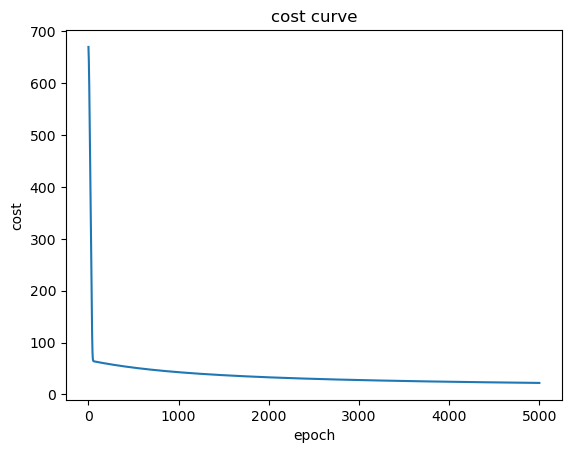

In [11]:
%time
theta = model_training_GD(X, y, ptint_plot=True)
theta

In [12]:
y_pred = predict(X_upd, theta)
y_pred = [0 if y < 0.5 else 1 for y in y_pred]

print(f'Accuracy: {accuracy_score(y, y_pred)}')

Accuracy: 0.96


### Root Mean Square Propagation, RMSProp

In [13]:
def update_theta_RMSP(X, y, theta, eg, lr, gamma = 0.9):
    eps = 1e-6
    n, M = X.shape
    current_predict = predict(X, theta)
    for i in range(len(theta)):
        dt = (np.dot(current_predict - y, X[:, i])) / n
        current_theta = theta[i]
        current_eg = gamma * eg[i] + (1 - gamma) * (dt**2)
        current_theta -= lr * dt/np.sqrt(current_eg + eps)
        np.put(eg, [i], current_eg)
        np.put(theta, [i], current_theta) # put заменяет элементы массива по указанному индексу заданными значениями
    return theta

In [14]:
def model_training_RMSP(X, y, lr = 0.01, epochs = 5000, ptint_plot=False):
    X_upd = np.c_[np.ones(X.shape[0]), X]
    theta = np.ones(X_upd.shape[1])
    eg = np.ones(X_upd.shape[1])
    costs = []
    for epoch in range(epochs):
        theta = update_theta_RMSP(X_upd, y, theta, eg, lr)
        cost = cost_function(X_upd, y, theta)
        costs.append(cost)
    if ptint_plot:
        plt.plot(range(epochs), costs)
        plt.xlabel("epoch")
        plt.ylabel("cost")
        plt.title("cost curve")
    return theta

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 2.86 µs


array([-21.59543852,  -3.04512862,  -5.0605437 ,   7.00631313,
        12.34138501])

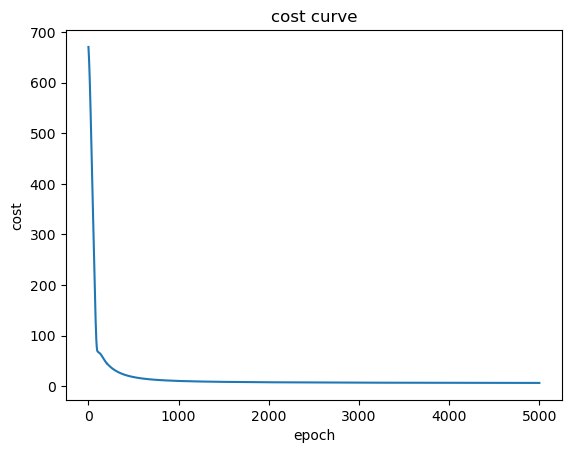

In [15]:
%time
theta = model_training_RMSP(X, y, ptint_plot=True)
theta

In [16]:
y_pred = predict(X_upd, theta)
y_pred = [0 if y < 0.5 else 1 for y in y_pred]

print(f'Accuracy: {accuracy_score(y, y_pred)}')

Accuracy: 0.97


### Nesterov–accelerated Adaptive Moment Estimation, Nadam

In [17]:
def update_theta_NADAM(X, y, theta, v, lr, gamma = 0.9):
    eps = 1e-6
    n, M = X.shape
    current_predict = predict(X, theta)
    for i in range(len(theta)):
        dt = (np.dot(current_predict - y, X[:, i])) / n
        current_theta = theta[i]
        current_v = gamma * v[i] + lr * dt
        current_theta -= current_v
        np.put(v, [i], current_v)
        np.put(theta, [i], current_theta) # put заменяет элементы массива по указанному индексу заданными значениями
    return theta

In [18]:
def model_training_NADAM(X, y, lr = 0.01, epochs = 5000, ptint_plot=False):
    X_upd = np.c_[np.ones(X.shape[0]), X]
    theta = np.ones(X_upd.shape[1])
    v = np.ones(X_upd.shape[1])
    costs = []
    for epoch in range(epochs):
        theta = update_theta_NADAM(X_upd, y, theta, v, lr)
        cost = cost_function(X_upd, y, theta)
        costs.append(cost)
    if ptint_plot:
        plt.plot(range(epochs), costs)
        plt.xlabel("epoch")
        plt.ylabel("cost")
        plt.title("cost curve")
    return theta

CPU times: user 1 µs, sys: 0 ns, total: 1 µs
Wall time: 2.62 µs


array([-8.68333514, -3.13675432, -3.24591915,  5.79581651,  5.46437119])

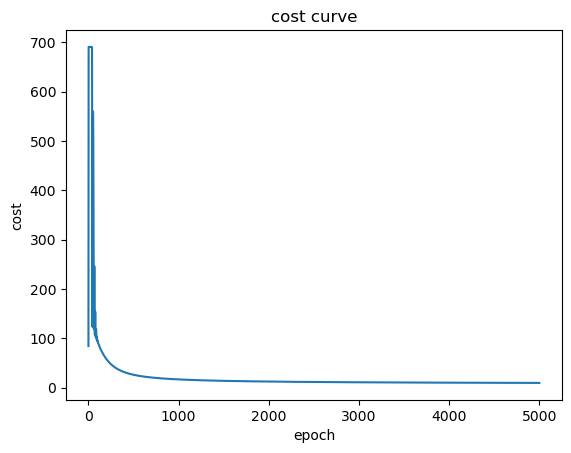

In [19]:
%time
theta = model_training_NADAM(X, y, ptint_plot=True)
theta

In [20]:
y_pred = predict(X_upd, theta)
y_pred = [0 if y < 0.5 else 1 for y in y_pred]

print(f'Accuracy: {accuracy_score(y, y_pred)}')

Accuracy: 0.97
